In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import numpy as np
import os

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        x = x.transpose(3, 2).contiguous()
        return x.view(x.size(0), -1)

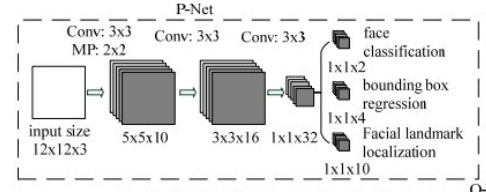

In [26]:
class PNet(nn.Module):
    def __init__(self):
        super(PNet, self).__init__()
        
        self.feature_extractor = nn.Sequential()
        self.feature_extractor_modules = [
                                         ("conv_1", nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0)),
                                         ("prelu_1", nn.PReLU(10)),
                                         ("max_pool", nn.MaxPool2d(kernel_size=2)),
                                         ("conv_2", nn.Conv2d(in_channels=10, out_channels=16, kernel_size=3, stride=1, padding=0)),
                                         ("prelu_2", nn.PReLU(16)),
                                         ("conv_3", nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0))
                                         ]
        for name, module in self.feature_extractor_modules:
            self.feature_extractor.add_module(name, module)
        
        self.clsf = nn.Conv2d(in_channels=32, out_channels=2, kernel_size=1, stride=1, padding=0)
        self.regresor = nn.Conv2d(in_channels=32, out_channels=4, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        features_map = self.feature_extractor(x)
        clsf_out = self.clsf(features_map)
        probs = F.softmax(clsf_out, dim=1)
        regresor_out = self.regresor(features_map)
        return regresor_out, probs
                                          

In [30]:
test_pnet = PNet()
pnet_input = torch.rand((1, 3, 112, 112))
pnet_reg, pnet_class = test_pnet(pnet_input)
pnet_reg.shape, pnet_class.shape

(torch.Size([1, 4, 51, 51]), torch.Size([1, 2, 51, 51]))

In [29]:
pnet_class[0, 0, 3, 3] + pnet_class[0, 1, 3, 3]

tensor(1., grad_fn=<AddBackward0>)

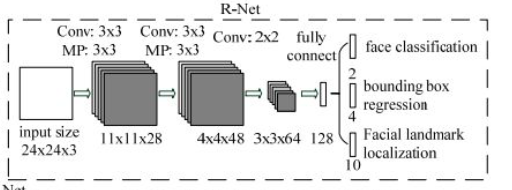

In [31]:
9*64

576

In [40]:
class RNet(nn.Module):
    def __init__(self):
        super(RNet, self).__init__()
        #self.model_path,_ = os.path.split(os.path.realpath(__file__))
        self.feature_extractor = nn.Sequential()
        self.feature_extractor_modules = [
                                         ("conv_1", nn.Conv2d(in_channels=3, out_channels=28, kernel_size=3, stride=1, padding=0)),
                                         ("prelu_1", nn.PReLU(28)),
                                         ("max_pool_1", nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)),
                                         ("conv_2", nn.Conv2d(in_channels=28, out_channels=48, kernel_size=3, stride=1, padding=0)),
                                         ("max_pool_2", nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)),
                                         ("prelu_2", nn.PReLU(48)),
                                         ("conv_3", nn.Conv2d(in_channels=48, out_channels=64, kernel_size=2, stride=1, padding=0)),
                                         ('prelu_3', nn.PReLU(64)),
                                         ("flatten", Flatten()),
                                         ('fc', nn.Linear(576, 128)),
                                         ('prelu_4', nn.PReLU(128))
                                         ]
        for name, module in self.feature_extractor_modules:
            self.feature_extractor.add_module(name, module)
            
        self.face_clsf = nn.Linear(128, 2)
        self.regresion = nn.Linear(128, 4)
        
    def forward(self, x):
        feature_map = self.feature_extractor(x)
        face_clsf_out = self.face_clsf(feature_map)
        face_clsf_probs = F.softmax(face_clsf_out, dim=1)
        regresion_out = self.regresion(feature_map)

        return regresion_out, face_clsf_probs
        

In [41]:
rnet = RNet()
rnet_out = rnet(torch.rand((1, 3, 24, 24)))

In [42]:
rnet_out

(tensor([[-0.0334,  0.0529, -0.0768,  0.0056]], grad_fn=<AddmmBackward0>),
 tensor([[0.4734, 0.5266]], grad_fn=<SoftmaxBackward0>))

In [46]:
rnet = RNet()
rnet_out = rnet(torch.rand((1, 3, 24, 24)))
rnet_out

(tensor([[-0.0312, -0.0020, -0.0181,  0.0591]], grad_fn=<AddmmBackward0>),
 tensor([[0.5298, 0.4702]], grad_fn=<SoftmaxBackward0>))

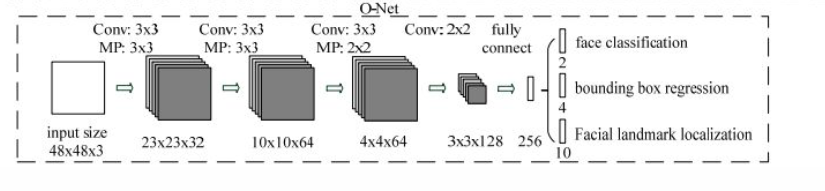

In [63]:
class ONet(nn.Module):
    def __init__(self):
        super(ONet, self).__init__()
        #self.model_path,_ = os.path.split(os.path.realpath(__file__))
        self.feature_extractor = nn.Sequential()
        self.feature_extractor_modules = [
                                         ("conv_1", nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0)),
                                         ("prelu_1", nn.PReLU(32)),
                                         ("max_pool_1", nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)),
                                         ("conv_2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)),
                                         ('prelu2', nn.PReLU(64)),
                                         ("max_pool_2", nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)),
                                         ("prelu_2", nn.PReLU(64)),
                                         ("conv_3", nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)),
                                         ('prelu_3', nn.PReLU(64)),
                                         ('max_pool_3', nn.MaxPool2d(2, 2, ceil_mode=True)),
                                         ("conv_4", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1, padding=0)),
                                         ('prelu_4', nn.PReLU(128)),
                                         ("flatten", Flatten()),
                                         ('conv_5', nn.Linear(1152, 256)),
                                         ('dropout', nn.Dropout(0.25)),
                                         ('prelu_5', nn.PReLU(256)),
                                         ]
        for name, module in self.feature_extractor_modules:
            self.feature_extractor.add_module(name, module)
        
        self.clsf = nn.Linear(256, 2)
        self.regresor = nn.Linear(256, 4)
        self.landmark = nn.Linear(256, 10)
        #weights = np.load(os.path.join(self.model_path, 'weights', 'onet.npy'), allow_pickle=True)[()]
        #for n, p in self.named_parameters():
         #   p.data = torch.FloatTensor(weights[n])

    def forward(self, x):
        feature_map = self.feature_extractor(x)
        clsf_out = self.clsf(feature_map)
        clsf_probs = F.softmax(clsf_out, dim=1)
        regresion_out = self.regresor(feature_map)
        landmarks_out = self.landmark(feature_map)
        return landmarks_out, regresion_out, clsf_probs

In [64]:
onet = ONet()
onet(torch.rand((1, 3, 48, 48)))

(tensor([[ 0.0135, -0.0291, -0.0323, -0.0460,  0.0274,  0.0377, -0.0120,  0.0212,
          -0.0371,  0.0792]], grad_fn=<AddmmBackward0>),
 tensor([[ 0.0397, -0.0261, -0.0481,  0.0365]], grad_fn=<AddmmBackward0>),
 tensor([[0.4839, 0.5161]], grad_fn=<SoftmaxBackward0>))

In [68]:
def _generate_bboxes(probs: np.array, offsets: torch.tensor, scale, threshold: float):
    """
       Generate bounding boxes at places where there is probably a face.
       batch_size = 1
       probs - output probs of model, shape = [height, width]
       offsets - output regressor of model, shape = [batch_size, 4, height, width]
    """
    stride = 2
    cell_size = 12
    
    # choose elements with prob> threshold
    inds = np.where(probs > threshold) # tuple(np.array (idx along y), np.array (idx along x))
    
    # if there is no box, return None
    if inds[0].size == 0:
        return np.array([])

    tx1, ty1, tx2, ty2 = [offsets[0, i, inds[0], inds[1]] for i in range(4)]
    # txi.shape = (num_boxes)

    offsets = np.array([tx1, ty1, tx2, ty2]) # shape = (4, num_boxes)
    score = probs[inds[0], inds[1]]
    # score.shape = (num_boxes)

    # P-Net is applied to scaled images, so we need to rescale bounding boxes back
    bounding_boxes = np.vstack([
        np.round((stride*inds[1] + 1.0)/scale),
        np.round((stride*inds[0] + 1.0)/scale),
        np.round((stride*inds[1] + 1.0 + cell_size)/scale),
        np.round((stride*inds[0] + 1.0 + cell_size)/scale),
        score, offsets
    ])

    return bounding_boxes.T # shape = (num_boxes, 9)

In [137]:
def nms(boxes, overlap_threshold=0.5, mode='union'):
    """ Pure Python NMS baseline. """
    x1 = boxes[:, 0] # shape=(num_boxes)
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    scores = boxes[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1) # shape=(num_boxes)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h

        if mode == 'min':
            ovr = inter / np.minimum(areas[i], areas[order[1:]])
        else:
            ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= overlap_threshold)[0]
        order = order[inds + 1]

    return keep

In [283]:
img = cv2.imread(file, cv2.COLOR_RGB2BGR)
img.shape

(768, 1024, 3)

In [140]:
from PIL import Image
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt

def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()

to_tensor = transforms.ToTensor()

def val_transform(img):
    """
    Transform image (pil.image(image_path)) to tensor with shape: (num_channels, width, height) 
    and add the first dimension to make batch with size 1. There is no need normalization, becouse
    neural net do this by himself.
    """
    img_tensor = to_tensor(img)
    # return batch wiht size 1
    return img_tensor.unsqueeze(0)

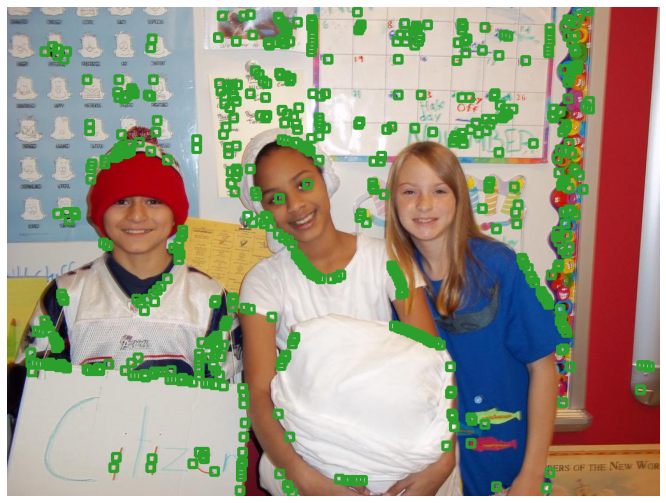

array([181., 135., 193., 147.])

In [326]:
def show_result_pnet(image_path, pnet_model, scale=1, threshold=0.4955):
    img = cv2.imread(file, cv2.COLOR_RGB2BGR)
    img_t = val_transform(img)
    model_output = pnet_model(img_t)
    probs = model_output[1].data.numpy()[0, 1, :, :]
    offsets = model_output[0].data.numpy()
    boxes = _generate_bboxes(probs, offsets, scale, threshold)
    if len(boxes) == 0:
        return None
    
    keep = nms(boxes[:, 0:5], overlap_threshold=threshold)
    boxes = boxes[keep]
    for i in range(len(boxes)):
        x1, y1, x2, y2 = map(int, boxes[i][:4])
        image = cv2.rectangle(img, (x1, y1), (x2, y2), np.array(color) * 255, 3)
    show_image(image)
    return boxes

boxes = show_result_pnet(file, test_pnet)
boxes[0, :4]

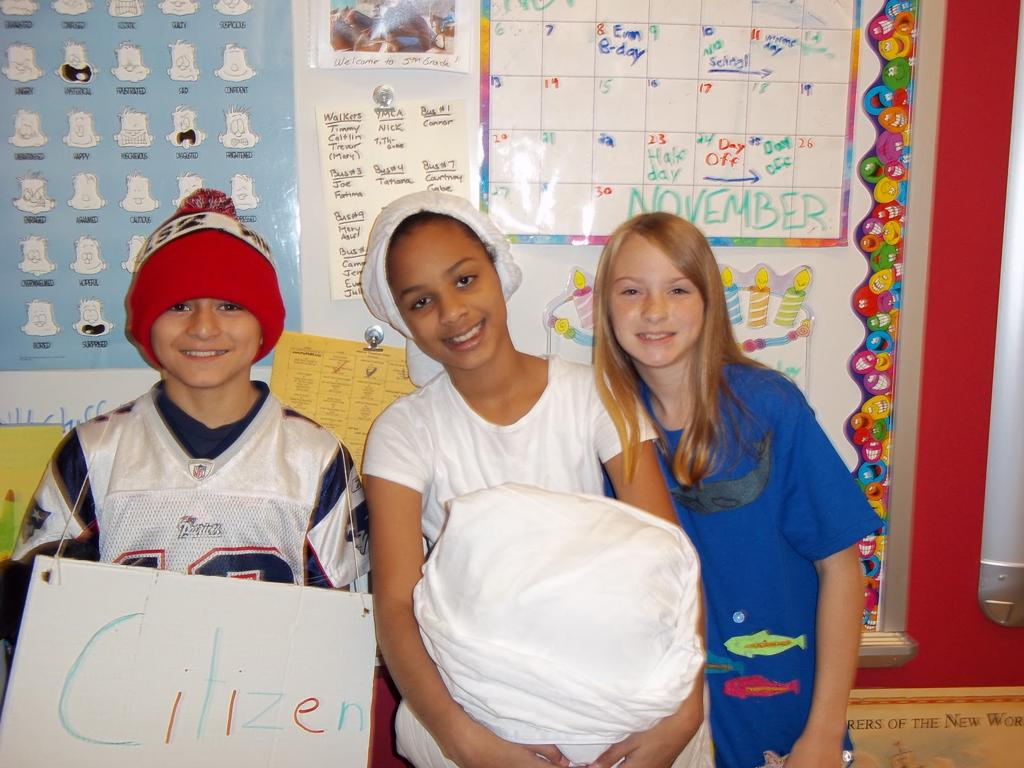

In [308]:
file = "images/test8.jpg"
image = Image.open(file)
image

In [307]:
image.getcolors

AttributeError: 'numpy.ndarray' object has no attribute 'getcolors'

In [216]:
img_t = val_transform(img)
img_t.shape

torch.Size([1, 3, 768, 1024])

In [217]:
offsets, probs = test_pnet(img_t)

In [219]:
probs = probs.data.numpy()[0, 1, :, :]
offsets = offsets.data.numpy()

In [240]:
768//12

64

In [257]:
boxes = _generate_bboxes(probs, offsets, 1/5, 0.5)
boxes.shape

(16, 9)

In [258]:
keep = nms(boxes[:, 0:5], overlap_threshold=0.5)

In [259]:
keep

[12, 15, 5, 0, 9, 2]

In [260]:
boxes = boxes[keep, 0:5]

In [261]:
boxes

array([[2.36500000e+03, 2.75000000e+02, 2.42500000e+03, 3.35000000e+02,
        5.02785861e-01],
       [2.80500000e+03, 2.75000000e+02, 2.86500000e+03, 3.35000000e+02,
        5.01187444e-01],
       [2.29500000e+03, 2.75000000e+02, 2.35500000e+03, 3.35000000e+02,
        5.00796676e-01],
       [1.56500000e+03, 2.75000000e+02, 1.62500000e+03, 3.35000000e+02,
        5.00576735e-01],
       [2.33500000e+03, 2.75000000e+02, 2.39500000e+03, 3.35000000e+02,
        5.00432968e-01],
       [2.02500000e+03, 2.75000000e+02, 2.08500000e+03, 3.35000000e+02,
        5.00124574e-01]])

In [265]:
x1, y1, x2, y2 = map(int, boxes[2][:-1])
x1, y1, x2, y2 

(2295, 275, 2355, 335)

In [263]:
import seaborn as sns
palette = sns.color_palette(None, 5)
color = palette[2]

In [314]:
x1, y1, x2, y2 = (181, 135, 193, 197)

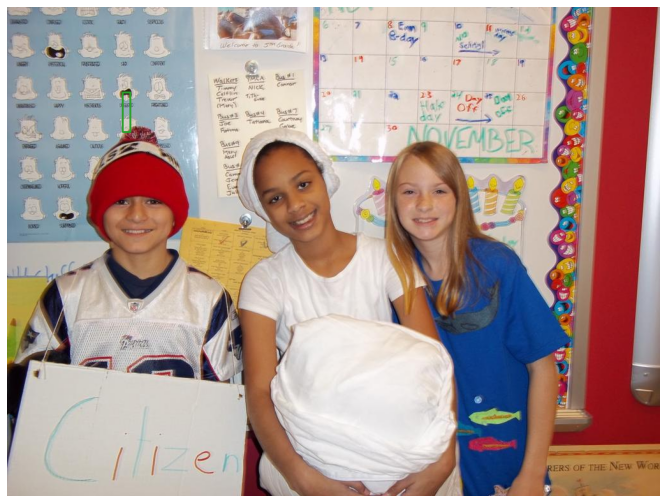

In [317]:
x1, y1, x2, y2 = (181, 135, 193, 197)
img = cv2.imread(file, cv2.COLOR_BGR2RGB)
image = cv2.rectangle(img, (x1, y1), (x2, y2), np.array(color) * 255, 2)
show_image(image)